***SOC Estimation***

In [1]:
#Import Libs

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Choose working directory

In [5]:
os.chdir('/content/drive/MyDrive/SOC_DATA/')
cwd = os.getcwd()

In [6]:
# Folder SOC DATA has all the required csvs 25degC, 10degC, 0degC, -10degC, and -20degC,
csv_list = []
start_time_stamp = dict ()
import collections as coll
for file in os.listdir(cwd):
  if any(substring in file for substring in ['Charge', 'Mixed']):
    csv_list.append(cwd +'/'+ file)
    df = pd.read_csv(file,nrows=26, header=[25,26], index_col=0, parse_dates=True)
    start_time_stamp[str(df.first_valid_index())] = file
    file_time_stamp_dict = coll.OrderedDict(sorted(start_time_stamp.items()))
files_dict = file_time_stamp_dict.copy()
# files_dict has all the file names and the corresponding path

Gather data from Csv files
& Order data based on time stamp


---



In [7]:
#Assuming battery operation will be in sequence of charge - discharge- charge
# Organizing the files in the sequence and removing irrelevant files
discharge = 0
charge = 0
for key, value in files_dict.items():
  if not discharge and any(substring in value for substring in ['Mixed']):
    discharge = 1 
    charge = 0
  elif not charge and any(substring in value for substring in ['Charge']):
    if not charge and not discharge:
      file_time_stamp_dict.pop(key)
    charge = 1
    discharge = 0
  elif discharge and any(substring in value for substring in ['Mixed']):
    file_time_stamp_dict.pop(key)
  elif charge and any(substring in value for substring in ['Charge']):
    file_time_stamp_dict.pop(key)

df_csv_path =pd.DataFrame.from_dict(file_time_stamp_dict, orient='index',
                       columns=[ 'File_Name'])
# df_csv_path has all the cleaned files and their path
      

Data Integration and preprocessing

---



In [8]:
final_df = pd.DataFrame()
count =0 
# Loop through all files and combine all csvs into one dataframe indexed by timestamp
# Create field soc - dependent variable
for file in df_csv_path['File_Name']:
    temp_df = pd.read_csv(file, header=[25,26], index_col=0, parse_dates=True)
    temp_df.columns = temp_df.columns.droplevel(1) 
    temp_df = temp_df[['Voltage', 'Current', 'Temperature','Capacity']]
    if any(substring in file for substring in ['Mixed']):
      temp_df['SOC'] = (temp_df['Capacity'] + abs(temp_df['Capacity'].min()))/abs(temp_df['Capacity'].min())
    elif any(substring in file for substring in ['Charge']):
      temp_df['SOC'] = (temp_df['Capacity'])/abs(temp_df['Capacity'].max())
    else:
      pass    
    final_df = pd.concat([final_df, temp_df], ignore_index=True)
    final_df = final_df[['Voltage', 'Current', 'Temperature','SOC']]
final_df.shape
# final_df Final data used for modelling

<ipython-input-8-e0face66e675>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['SOC'] = (temp_df['Capacity'])/abs(temp_df['Capacity'].max())


(2461347, 4)

In [9]:
final_df.describe()
# Summary statistics

Time Stamp,Voltage,Current,Temperature,SOC
count,2.461347e+06,2.461347e+06,2.461347e+06,2.461347e+06
mean,3.647913e+00,-1.207744e+00,3.882072e+00,4.727383e-01
std,2.874562e-01,2.394110e+00,1.479316e+01,3.156153e-01
min,2.788130e+00,-1.809828e+01,-2.061107e+01,0.000000e+00
25%,3.451750e+00,-2.375300e+00,-8.833320e+00,1.980219e-01
50%,3.645710e+00,-5.797800e-01,7.361100e-01,4.640827e-01
75%,3.869100e+00,0.000000e+00,2.376583e+01,7.544310e-01
max,4.239900e+00,6.004720e+00,2.628963e+01,1.000506e+00


In [10]:
final_df.isna().any()
# Missing value check

Time Stamp
Voltage        False
Current        False
Temperature    False
SOC            False
dtype: bool

Data Viz

---



/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


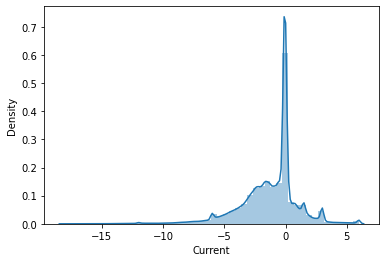

In [11]:
#Pdf of current
sns.distplot(final_df['Current'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


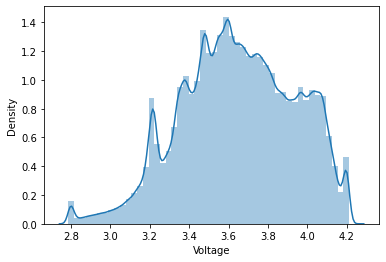

In [12]:
# pdf of voltage
sns.distplot(final_df['Voltage'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


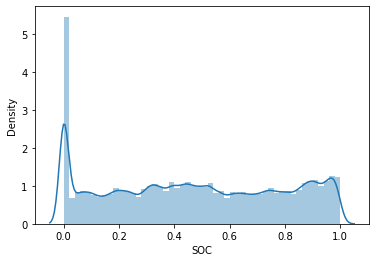

In [13]:
sns.distplot(final_df['SOC'])
#pdf of SOC 

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


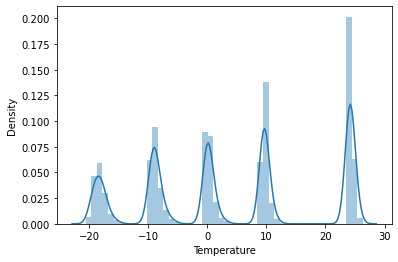

In [14]:
sns.distplot(final_df['Temperature'])
#pdf of temperature
#5 different temperatures are considered

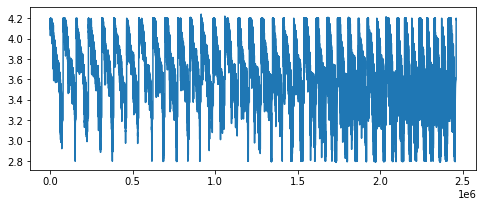

In [15]:
final_df['Voltage'].plot(figsize = (8,3))
# Voltage with respect to time

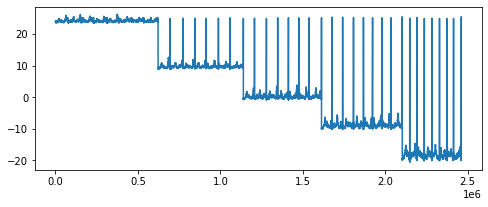

In [16]:
final_df['Temperature'].plot(figsize = (8,3))
# Temperature w.r.t time

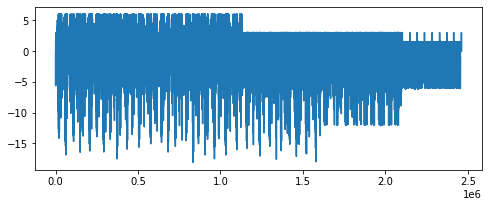

In [17]:
final_df['Current'].plot(figsize = (8,3))
#Current w.r.t time

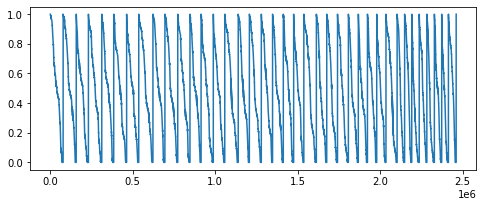

In [18]:
final_df['SOC'].plot(figsize = (8,3))
# SOC w.r.t time

Data Normalization & Test Train Split

---



In [19]:
final_df_normal = (final_df-final_df.mean())/final_df.std()
#Normalizing the data for speeding up gradient descent

In [20]:
#test train split
test_size = 500000
df_train = final_df_normal[:-test_size]
df_test = final_df_normal[-test_size:]

Model Building

---



Benchmarking using simple linear model

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
df_X_train = df_train.copy()
df_y_train = df_X_train.pop('SOC')

df_X_test = df_test.copy()
df_y_test = df_X_test.pop('SOC')

In [23]:
# Benchmarking helps in understanding minimum performance expectation
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np

regr = linear_model.LinearRegression()

scores_mae = cross_val_score(regr, df_X_train, df_y_train, scoring='neg_mean_absolute_error', cv=10)
scores_rmse = cross_val_score(regr, df_X_train, df_y_train, scoring='neg_root_mean_squared_error', cv=10)

print (scores_mae.mean())
print (scores_rmse.mean())
# Mean absolute error and RMSE are considered as primary and secondary performance metrics

-0.19880933803506634
-0.258015485772966


Deep Neural Networks

In [24]:
# DNN Architecture 
# Scaled Exponential Linear Unit (SELU) activation is used
model = tf.keras.Sequential([ layers.Dense(32, activation='selu', input_shape=(df_X_train.shape[1],)),
                                 layers.Dense(64, activation='selu'),
                                 layers.Dense(64, activation='selu'),
                                 layers.Dense(1)])
#Stochastic gradient descent is used as optimizer
#learning rate is set at 0.05
model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.05), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Model fitting
Model_df = model.fit( df_X_train,df_y_train ,epochs=30,batch_size=32,validation_split=0.1)

Epoch 1/30
55163/55163 [==============================] - 155s 3ms/step - loss: 0.1083 - mae: 0.1083 - rmse: 0.1486 - val_loss: 0.2053 - val_mae: 0.2053 - val_rmse: 0.2545
Epoch 2/30
55163/55163 [==============================] - 155s 3ms/step - loss: 0.1032 - mae: 0.1032 - rmse: 0.1416 - val_loss: 0.1998 - val_mae: 0.1998 - val_rmse: 0.2624
Epoch 3/30
55163/55163 [==============================] - 154s 3ms/step - loss: 0.1023 - mae: 0.1023 - rmse: 0.1404 - val_loss: 0.1966 - val_mae: 0.1966 - val_rmse: 0.2677
Epoch 4/30
55163/55163 [==============================] - 150s 3ms/step - loss: 0.1015 - mae: 0.1015 - rmse: 0.1396 - val_loss: 0.1881 - val_mae: 0.1881 - val_rmse: 0.2401
Epoch 5/30
55163/55163 [==============================] - 149s 3ms/step - loss: 0.1010 - mae: 0.1010 - rmse: 0.1390 - val_loss: 0.2165 - val_mae: 0.2165 - val_rmse: 0.2878
Epoch 6/30
55163/55163 [==============================] - 150s 3ms/step - loss: 0.1007 - mae: 0.1007 - rmse: 0.1386 - val_loss: 0.2187 - val

In [32]:
#Model training performance
Model_stats = pd.DataFrame(Model_df.history)
Model_stats['epoch'] = Model_df.epoch
Model_stats.head()

,loss,mae,rmse,val_loss,val_mae,val_rmse,epoch
0,0.108327,0.108327,0.148621,0.205253,0.205253,0.254507,0
1,0.103248,0.103248,0.141571,0.199794,0.199794,0.262360,1
2,0.102267,0.102267,0.140406,0.196604,0.196604,0.267651,2
3,0.101514,0.101514,0.139577,0.188097,0.188097,0.240140,3
4,0.100988,0.100988,0.139010,0.216467,0.216467,0.287791,4


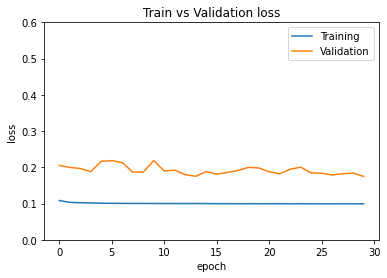

In [60]:
plt.plot(Model_stats.loss, label='Training')
plt.plot(Model_stats.val_loss, label='Validation')
plt.title('Train vs Validation loss')
plt.ylim([0, 0.6])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [34]:
# Testing model
prediction = model.predict(df_X_test).flatten()

15625/15625 [==============================] - 20s 1ms/step


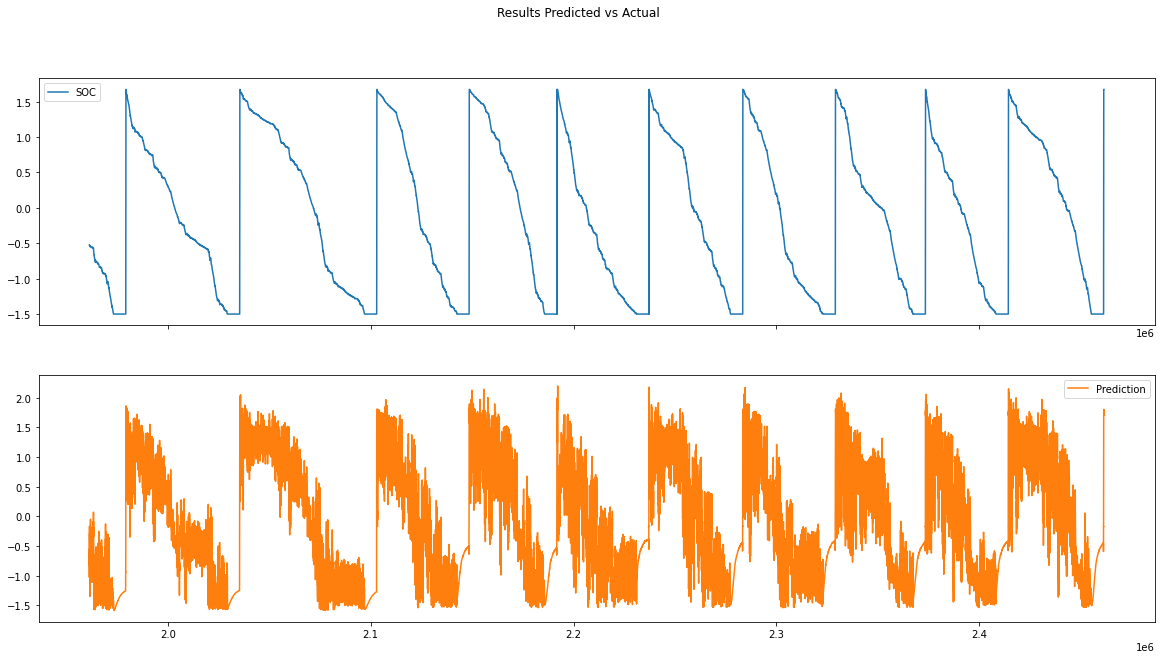

In [58]:
results = pd.DataFrame(df_y_test)
results['Prediction'] = prediction
_ = results.plot(subplots=True, figsize=(20,10), title='Results Predicted vs Actual')

LSTM Model - As temporal compontent is not considered in previous model,LSTM model is expected to give better results

In [24]:
# Data Preparation
df_X = df_train.copy()
df_y = df_X.pop('SOC').to_numpy()

df_X = df_X.to_numpy()
df_y = df_y.reshape(df_y.shape[0],1)

df_X_lstm = np.empty((0, 300, len(df_X[0])), float)
df_y_lstm = np.empty((0, 300, len(df_y[0])), float)

batch = int(len(df_X)/300)
for i in range(0, batch*300, 300):
  temp_x = np.array(df_X[i:i + 300]).reshape(1, 300, len(df_X[0]))
  temp_y = np.array(df_y[i:i + 300]).reshape(1, 300, len(df_y[0]))
  df_X_lstm = np.concatenate((df_X_lstm, temp_x))
  df_y_lstm = np.concatenate((df_y_lstm, temp_y))

df_X_lstm.shape


(6537, 300, 3)

In [26]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation

opt = tf.keras.optimizers.Adam(lr=0.00001)

model = Sequential()
model.add(LSTM(64, activation='selu',
                return_sequences=True,
                input_shape=(df_X_lstm.shape[1], df_X_lstm.shape[2])))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae',tf.keras.metrics.RootMeanSquaredError(name='rmse')])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 300, 64)           17408     
                                                                 
 dense_2 (Dense)             (None, 300, 64)           4160      
                                                                 
 dense_3 (Dense)             (None, 300, 1)            65        
                                                                 
Total params: 21,633
Trainable params: 21,633
Non-trainable params: 0
_________________________________________________________________
